<a href="https://colab.research.google.com/github/dimoynwa/Computer-vision-tasks/blob/main/Tennis_ball_detection_YOLOv9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train and test YOLOv9 on Tennis ball data

Steps in the tutorial:

- Environment setup
- Install libraries
- Download dataset from `roboflow`
- Train YOLOv9 on that dataset
- Deploy model to `roboflow`

## Environment

Check `python` and `pip` versions.

Make sure GPU is available using `nvidia-smi` command. It should return anything, this indicates that `cuda` is available

In [ ]:
!python --version
!pip --version

Python 3.10.12
pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [ ]:
!nvidia-smi

Fri Jul 12 13:39:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Configure **HOME** directory.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


Import `pytorch` and check `pytorch` and `cuda` versions.

In [ ]:
import torch

!nvcc --version
TORCH_VERSION = torch.__version__
CUDA_VERSION = torch.__version__.split('+')[-1]

print(f'Torch version: {TORCH_VERSION}')
print(f'CUDA version: {CUDA_VERSION}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Torch version: 2.3.0+cu121
CUDA version: cu121


## Install libraries

- Install `ultralytics` for YOLOv9 algorithm
- Install `roboflow` for dataset
- Install `supervision` for labeling and annotationg images and videos
- Install `clearml` for experiment tracking

In [ ]:
! pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/201.2 GB disk)


In [ ]:
!pip install roboflow supervision clearml

from IPython import display
display.clear_output()

import roboflow
print(f'Roboflow version: {roboflow.__version__}')

import supervision as sv
print(f'Supervision version: {sv.__version__}')

import clearml
print(f'ClearML version: {clearml.__version__}')

Roboflow version: 1.1.34
Supervision version: 0.21.0
ClearML version: 1.16.2


## Dataset

URL: https://universe.roboflow.com/tennisobjectdetect/tennis-ybzmd/dataset/6

We will train YOLOv9 on Tennis ball

In [ ]:
from google.colab import userdata
roboflow_api_key = userdata.get('roboflow_api_key')
print(f'Roboflow API key: {roboflow_api_key[:2]}**{roboflow_api_key[-2:]}')

%cd {HOME}

from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace("tennisobjectdetect").project("tennis-ybzmd")
version = project.version(6)
dataset = version.download("yolov9")


Roboflow API key: yh**ot
/content
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tennis-6 in yolov9:: 100%|██████████| 14742/14742 [00:02<00:00, 5539.80it/s]


## Explore dataset

In [ ]:
dataset.location

'/content/Tennis-6'

In [ ]:
import os
import supervision as sv

img_dir_path = os.path.join(dataset.location, 'train', 'images')
ann_dir_path = os.path.join(dataset.location, 'train', 'labels')
data_yaml_path = os.path.join(dataset.location, 'data.yaml')

supervision_ds = sv.DetectionDataset.from_yolo(
    images_directory_path=img_dir_path,
    annotations_directory_path=ann_dir_path,
    data_yaml_path=data_yaml_path)

In [ ]:
list(supervision_ds.images.keys())[:3]

['/content/Tennis-6/train/images/IMG_20220321_230417_jpg.rf.65252ffe571143933496019b752a9da5.jpg',
 '/content/Tennis-6/train/images/18_jpg.rf.346be81ff1d3b89262434ec721a490cc.jpg',
 '/content/Tennis-6/train/images/15d2618dcddc9e9c_jpg.rf.fcd27efdf6bce9b9ec89ef8ed3f52102.jpg']

Dataset len: 7062
Choosen: ['/content/Tennis-6/train/images/TennisBall9_jpg.rf.253ee2027236b9ba1c3d1a3137056c94.jpg', '/content/Tennis-6/train/images/IMG_20220321_150524_jpg.rf.2c2702afae0ca1528c8396e6c3f91fae.jpg', '/content/Tennis-6/train/images/3_00061_jpg.rf.7fd1631d0ced8d4b68a628a490c8fb80.jpg']
CLASS_NAME_DICT: {0: 'tennis-ball'}
Image shape: (640, 640, 3)
Detections: Detections(xyxy=array([[        292,         306,         350,         398]], dtype=float32), mask=None, confidence=None, class_id=array([0]), tracker_id=None, data={})
Image shape: (640, 640, 3)
Detections: Detections(xyxy=array([[        132,         109,         160,         137],
       [        332,         152,         411,         274],
       [         85,         510,         201,         627],
       [        332,         557,         376,         604]], dtype=float32), mask=None, confidence=None, class_id=array([0, 0, 0, 0]), tracker_id=None, data={})
Image shape: (640, 640, 3)
Detections: Detections(xyxy

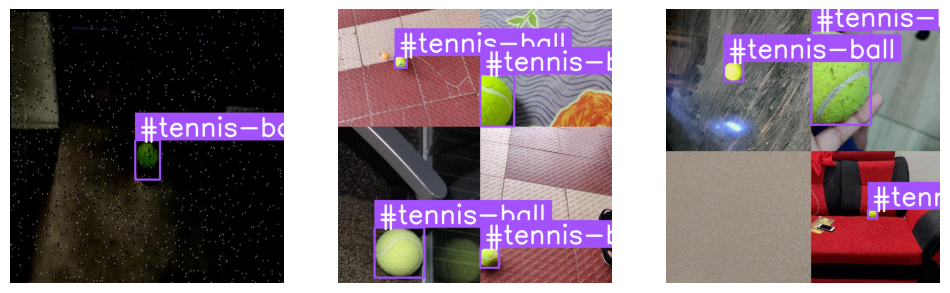

In [ ]:
import random
import cv2

len_ds = len(supervision_ds)
print(f'Dataset len: {len_ds}')

choosen = random.choices(list(supervision_ds.images.keys()), k=3)
print(f'Choosen: {choosen}')

box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

CLASS_NAME_DICT = { idx: label for idx, label in enumerate(supervision_ds.classes) }
print(f'CLASS_NAME_DICT: {CLASS_NAME_DICT}')

frames = []

for img_src in choosen:
  image = cv2.imread(img_src)
  detections = supervision_ds.annotations[img_src]

  labels = [
    f'#{CLASS_NAME_DICT[class_id]}'
    for class_id in detections.class_id
  ]

  print(f'Image shape: {image.shape}')
  print(f'Detections: {detections}')

  frame = box_annotator.annotate(image, detections)
  frame = label_annotator.annotate(frame, detections, labels=labels)

  frames.append(frame)

sv.plot_images_grid(frames, (1, len(frames)))

## Connect to Clear ML

In [ ]:
import clearml

clearml.browser_login()

# Clear log because Access and Secret keys are there
from IPython import display
display.clear_output()

## Move folders

YOLOv9 requires specific folder structure for training

In [ ]:
import yaml
dataset_name = 'Tennis-6'

with open(f'{HOME}/{dataset_name}/data.yaml') as f:
  ds_config = yaml.safe_load(f)

ds_config['train'] = 'train/images'
ds_config['val'] = 'valid/images'

with open(f'{HOME}/{dataset_name}/data.yaml', 'w') as f:
  yaml.dump(ds_config, f, default_flow_style=False, allow_unicode=True)

with open(f'{HOME}/{dataset_name}/data.yaml') as f:
  updated_config = yaml.safe_load(f)

updated_config

{'names': ['tennis-ball'],
 'nc': 1,
 'roboflow': {'license': 'CC BY 4.0',
  'project': 'tennis-ybzmd',
  'url': 'https://universe.roboflow.com/tennisobjectdetect/tennis-ybzmd/dataset/6',
  'version': 6,
  'workspace': 'tennisobjectdetect'},
 'test': '../test/images',
 'train': 'train/images',
 'val': 'valid/images'}

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

exists_model = os.path.exists('/content/drive/MyDrive/Data/tennis-best.pt')
print(f'Exists model: {exists_model}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Exists model: True


In [ ]:
# del supervision_ds

import gc
gc.collect()

26736

## Train YOLOv9

Device: cuda
Task name: yolov9s-tennis-ball-detection-100-epochs-auto-no-stop-resume
2024-07-12 13:57:45,607 - clearml.model - WARNING - Connecting multiple input models with the same name: `tennis-best`. This might result in the wrong model being used when executing remotely
Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Data/tennis-best.pt, data=/content/Tennis-6/data.yaml, epochs=100, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/content/drive/MyDrive/Data/tennis-best.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hy

100%|██████████| 755k/755k [00:00<00:00, 25.9MB/s]


TensorBoard: Start with 'tensorboard --logdir runs/detect/train', view at http://localhost:6006/

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     31104  ultralytics.nn.modules.block.ELAN1           [64, 64, 64, 32]              
  3                  -1  1     73984  ultralytics.nn.modules.block.AConv           [64, 128]                     
  4                  -1  1    258432  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 128, 128, 64, 3]        
  5                  -1  1    221568  ultralytics.nn.modules.block.AConv           [128, 192]                    
  6                  -1  1    579648  ultralytics.nn.modules.block.RepNCSPELAN4    [192, 192, 192, 96, 3

100%|██████████| 6.25M/6.25M [00:00<00:00, 131MB/s]


AMP: checks passed ✅


train: Scanning /content/Tennis-6/train/labels... 7062 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7062/7062 [00:04<00:00, 1708.60it/s]

train: WARNING ⚠️ /content/Tennis-6/train/images/2497e41cea655ddc_jpg.rf.0053cbd293dd577cce3a7bd84f743122.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Tennis-6/train/images/2497e41cea655ddc_jpg.rf.2b13967a274659869644485a3405e0c3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Tennis-6/train/images/2497e41cea655ddc_jpg.rf.2bd062b51e4d933b51afb23b6b67623c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Tennis-6/train/images/2497e41cea655ddc_jpg.rf.3c831cc2823c1c6e52e8375b97fd814c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Tennis-6/train/images/2497e41cea655ddc_jpg.rf.4dd0e08347f3ba6f01090b82418c97c2.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Tennis-6/train/images/2497e41cea655ddc_jpg.rf.9a561596f16a6f2b1613b13a7dac3213.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Tennis-6/train/images/2497e41cea655ddc_jpg.rf.9c4b388e906da955141b635d22295035.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Tennis-

train: New cache created: /content/Tennis-6/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

val: Scanning /content/Tennis-6/valid/labels... 183 images, 0 backgrounds, 0 corrupt: 100%|██████████| 183/183 [00:00<00:00, 1220.72it/s]

val: New cache created: /content/Tennis-6/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
Resuming training /content/drive/MyDrive/Data/tennis-best.pt from epoch 15 to 100 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.41G     0.7763     0.5669      1.148         56        640: 100%|█████████▉| 441/442 [04:13<00:00,  1.39it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

     15/100      5.51G     0.7761     0.5666      1.148         14        640: 100%|██████████| 442/442 [04:14<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]

                   all        183        244      0.934       0.73      0.767      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.44G     0.7742     0.5664      1.135         16        640: 100%|██████████| 442/442 [04:11<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        183        244      0.967      0.725      0.775      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.43G     0.7592     0.5617      1.133         27        640: 100%|██████████| 442/442 [04:19<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        183        244      0.924      0.742      0.773      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.46G     0.7605     0.5555      1.138         18        640: 100%|██████████| 442/442 [04:14<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        183        244      0.967      0.724      0.779      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.42G     0.7543     0.5487      1.132         14        640: 100%|██████████| 442/442 [04:16<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        183        244      0.917      0.758      0.798      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.48G     0.7296     0.5256      1.116         22        640: 100%|██████████| 442/442 [04:10<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        183        244      0.929       0.75      0.799      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.43G     0.7272     0.5272      1.108         17        640: 100%|██████████| 442/442 [04:13<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        183        244      0.978      0.731      0.803      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.44G     0.7331     0.5226      1.121         21        640: 100%|██████████| 442/442 [04:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]

                   all        183        244      0.957      0.728      0.789       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.43G     0.7226     0.5172      1.113         20        640: 100%|██████████| 442/442 [04:11<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

                   all        183        244      0.903      0.709      0.769      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.44G     0.7147     0.5137      1.106         32        640: 100%|██████████| 442/442 [04:11<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        183        244      0.953      0.748      0.814      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.44G     0.7055     0.4977      1.094         25        640: 100%|██████████| 442/442 [04:06<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        183        244      0.963      0.734      0.793      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.44G     0.7054     0.5054      1.093         20        640: 100%|██████████| 442/442 [04:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        183        244      0.942      0.739      0.778      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.44G     0.6973     0.4929      1.089         23        640: 100%|██████████| 442/442 [04:08<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        183        244      0.958      0.758      0.807      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.48G     0.6983     0.4903      1.085         21        640: 100%|██████████| 442/442 [04:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        183        244      0.941      0.742      0.782      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.43G     0.6933     0.4901      1.086         19        640: 100%|██████████| 442/442 [03:59<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

                   all        183        244      0.939      0.752      0.801      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.47G     0.6914     0.4947      1.089         19        640: 100%|██████████| 442/442 [04:04<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        183        244      0.949      0.766      0.828      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.43G     0.6858     0.4814      1.087         21        640: 100%|██████████| 442/442 [03:59<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]

                   all        183        244      0.936       0.75      0.804      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.47G     0.6778      0.479       1.08         26        640: 100%|██████████| 442/442 [03:59<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        183        244      0.941      0.754      0.804      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.44G     0.6708     0.4695      1.074         24        640: 100%|██████████| 442/442 [04:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

                   all        183        244      0.951      0.762      0.825      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.45G     0.6712     0.4652       1.07         18        640: 100%|██████████| 442/442 [04:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        183        244      0.978      0.762      0.805      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.45G     0.6707     0.4777      1.075         18        640: 100%|██████████| 442/442 [04:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

                   all        183        244      0.942      0.762      0.812      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.47G     0.6533     0.4615      1.066         11        640: 100%|██████████| 442/442 [03:58<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        183        244      0.984       0.75      0.811      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.46G     0.6643     0.4669       1.07         14        640: 100%|██████████| 442/442 [04:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]

                   all        183        244      0.994      0.728      0.805       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.47G     0.6574     0.4559      1.071         14        640: 100%|██████████| 442/442 [03:59<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        183        244       0.93      0.761      0.811      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.44G     0.6493     0.4452      1.057         30        640: 100%|██████████| 442/442 [03:59<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        183        244      0.939      0.779      0.813       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.47G     0.6453     0.4464      1.049         23        640: 100%|██████████| 442/442 [04:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]

                   all        183        244      0.948      0.754      0.812      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.46G     0.6425     0.4455      1.049         19        640: 100%|██████████| 442/442 [03:59<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        183        244      0.957      0.735        0.8      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.46G      0.639     0.4453      1.042         20        640: 100%|██████████| 442/442 [04:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        183        244      0.922       0.77      0.816      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.44G     0.6288     0.4309       1.04         23        640: 100%|██████████| 442/442 [04:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        183        244      0.967       0.75      0.813      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.44G     0.6249     0.4337      1.043         23        640: 100%|██████████| 442/442 [04:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all        183        244      0.926      0.772      0.821      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.44G     0.6204     0.4307      1.044         19        640: 100%|██████████| 442/442 [03:57<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        183        244      0.954      0.757      0.825      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.46G     0.6233     0.4367      1.048         22        640: 100%|██████████| 442/442 [03:57<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        183        244      0.959      0.734      0.801      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.45G     0.6131     0.4282      1.039         16        640: 100%|██████████| 442/442 [03:58<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        183        244      0.969      0.764      0.827      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.44G     0.6102     0.4199      1.034         20        640: 100%|██████████| 442/442 [04:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        183        244      0.978      0.762      0.834      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.43G     0.6134     0.4245      1.041         19        640: 100%|██████████| 442/442 [03:59<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all        183        244      0.946      0.766      0.828      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.47G     0.6116     0.4195      1.041         22        640: 100%|██████████| 442/442 [03:55<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        183        244      0.984      0.764      0.831       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.46G     0.6012     0.4183      1.032         37        640: 100%|██████████| 442/442 [03:51<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        183        244      0.947      0.746      0.809      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.48G     0.5964     0.4106       1.03         21        640: 100%|██████████| 442/442 [03:51<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        183        244      0.956      0.775      0.831       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.43G     0.5959     0.4059       1.02         20        640: 100%|██████████| 442/442 [03:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        183        244      0.949      0.768      0.821      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.47G      0.589     0.4041      1.015         19        640: 100%|██████████| 442/442 [03:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        183        244      0.949      0.763      0.826      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.44G     0.5911     0.4071      1.018         26        640: 100%|██████████| 442/442 [03:47<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]

                   all        183        244      0.944      0.758      0.812       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.45G     0.5914     0.4091      1.021         16        640: 100%|██████████| 442/442 [03:51<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        183        244      0.959      0.758      0.826      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.45G     0.5793     0.3963      1.012         31        640: 100%|██████████| 442/442 [03:49<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        183        244      0.962       0.77      0.829      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.48G     0.5764     0.3934      1.007         27        640: 100%|██████████| 442/442 [03:47<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        183        244      0.943      0.775       0.83      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.44G     0.5815     0.4006      1.018         30        640: 100%|██████████| 442/442 [03:54<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        183        244      0.927      0.779       0.84      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.44G     0.5684     0.3918      1.003         19        640: 100%|██████████| 442/442 [03:54<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        183        244      0.905      0.783      0.838        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.46G     0.5683     0.3845      1.002         28        640: 100%|██████████| 442/442 [03:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        183        244      0.922      0.766      0.827      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.46G     0.5666     0.3841          1         18        640: 100%|██████████| 442/442 [03:56<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

                   all        183        244      0.939      0.762      0.825      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.45G     0.5593     0.3742      1.001         26        640: 100%|██████████| 442/442 [03:51<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        183        244      0.949      0.764      0.827      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       5.5G     0.5669      0.389      1.003         13        640: 100%|██████████| 442/442 [03:53<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all        183        244      0.953      0.758       0.84      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.43G     0.5592     0.3879      1.002         11        640: 100%|██████████| 442/442 [03:54<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

                   all        183        244      0.944      0.775      0.836      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.46G     0.5511     0.3802     0.9972         15        640: 100%|██████████| 442/442 [03:50<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        183        244       0.95      0.772      0.842      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.45G     0.5464     0.3781     0.9933         24        640: 100%|██████████| 442/442 [04:14<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        183        244      0.948      0.775       0.84       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.48G     0.5513     0.3818     0.9995         14        640: 100%|██████████| 442/442 [04:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]

                   all        183        244      0.956      0.762      0.839      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.48G     0.5431     0.3741     0.9913         19        640: 100%|██████████| 442/442 [03:50<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        183        244      0.945      0.766      0.842      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.46G     0.5414     0.3721     0.9901         28        640: 100%|██████████| 442/442 [03:56<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

                   all        183        244      0.964      0.774       0.84      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.45G     0.5378     0.3695     0.9897         22        640: 100%|██████████| 442/442 [03:59<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        183        244      0.954      0.775      0.842        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.46G     0.5316     0.3668     0.9862         17        640: 100%|██████████| 442/442 [04:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        183        244      0.975      0.758      0.844      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.43G     0.5265     0.3581     0.9842         21        640: 100%|██████████| 442/442 [04:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]

                   all        183        244       0.95      0.784       0.84      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.46G     0.5153     0.3482     0.9783         12        640: 100%|██████████| 442/442 [03:58<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        183        244      0.967      0.779      0.844      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.43G     0.5211     0.3544     0.9803         14        640: 100%|██████████| 442/442 [03:55<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.75it/s]

                   all        183        244      0.952      0.775      0.849      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.48G     0.5156     0.3504     0.9754         24        640: 100%|██████████| 442/442 [03:55<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        183        244      0.947      0.766      0.847      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.41G      0.514      0.353     0.9749         21        640: 100%|██████████| 442/442 [04:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        183        244      0.955      0.762      0.843      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.46G     0.5197     0.3524     0.9809         20        640: 100%|██████████| 442/442 [03:57<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]

                   all        183        244      0.954       0.77      0.847      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.44G      0.506     0.3451     0.9717         22        640: 100%|██████████| 442/442 [04:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        183        244      0.967      0.762      0.848      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.46G     0.5103     0.3475     0.9702         16        640: 100%|██████████| 442/442 [03:57<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]

                   all        183        244      0.964      0.762      0.854      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.45G     0.5012     0.3383      0.966         12        640: 100%|██████████| 442/442 [03:59<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        183        244      0.971      0.762      0.852      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.48G     0.5037     0.3407     0.9678         20        640: 100%|██████████| 442/442 [03:56<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        183        244      0.979      0.762      0.845      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.45G     0.4978     0.3381     0.9704         18        640: 100%|██████████| 442/442 [03:55<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        183        244      0.962       0.77      0.851      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.44G     0.4951     0.3342     0.9662         20        640: 100%|██████████| 442/442 [03:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]

                   all        183        244      0.964      0.779      0.851      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.45G     0.4953     0.3358     0.9706         11        640: 100%|██████████| 442/442 [03:49<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        183        244      0.958      0.775      0.851      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.48G     0.4857     0.3307     0.9643         19        640: 100%|██████████| 442/442 [03:52<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        183        244      0.964      0.777      0.849      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.45G     0.4782     0.3273      0.961         18        640: 100%|██████████| 442/442 [03:53<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        183        244      0.936      0.779      0.848      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.43G      0.482     0.3283     0.9655         24        640: 100%|██████████| 442/442 [03:55<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all        183        244      0.952      0.775      0.849      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.47G     0.4816     0.3265      0.966         28        640: 100%|██████████| 442/442 [03:55<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        183        244      0.951      0.775      0.848      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.46G     0.4745     0.3219     0.9626         32        640: 100%|██████████| 442/442 [03:54<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

                   all        183        244      0.939      0.787       0.85      0.707


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.43G      0.453     0.2818     0.9413         14        640: 100%|██████████| 442/442 [03:51<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]

                   all        183        244      0.947      0.783      0.849      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.44G     0.4418     0.2765     0.9357         22        640: 100%|██████████| 442/442 [03:47<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        183        244      0.937      0.792      0.851      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.43G     0.4392     0.2715     0.9327          8        640: 100%|██████████| 442/442 [03:48<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        183        244      0.937      0.793      0.851      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.44G     0.4301     0.2645     0.9306         18        640: 100%|██████████| 442/442 [03:46<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        183        244      0.937      0.792      0.855       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.43G     0.4252     0.2653     0.9286         17        640: 100%|██████████| 442/442 [03:49<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        183        244      0.937      0.794      0.855      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.44G     0.4203     0.2586     0.9232         13        640: 100%|██████████| 442/442 [03:51<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        183        244      0.937      0.795      0.855      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.43G     0.4192      0.257     0.9245          8        640: 100%|██████████| 442/442 [03:48<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        183        244      0.937       0.79      0.855      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.44G     0.4152     0.2563     0.9219         13        640: 100%|██████████| 442/442 [03:47<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        183        244      0.938      0.791      0.855      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.43G     0.4079     0.2523     0.9149         15        640: 100%|██████████| 442/442 [03:45<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        183        244      0.935      0.791      0.857      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.44G     0.4044     0.2506     0.9165          8        640: 100%|██████████| 442/442 [03:45<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        183        244      0.933      0.793      0.857      0.722



86 epochs completed in 5.798 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 15.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9s summary (fused): 486 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


                   all        183        244      0.947      0.766      0.847      0.727
Speed: 0.4ms preprocess, 8.2ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/detect/train


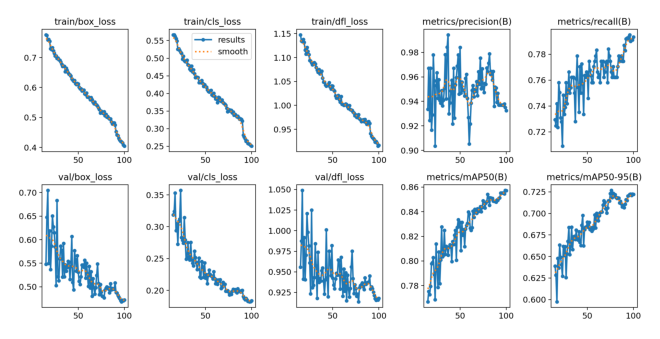

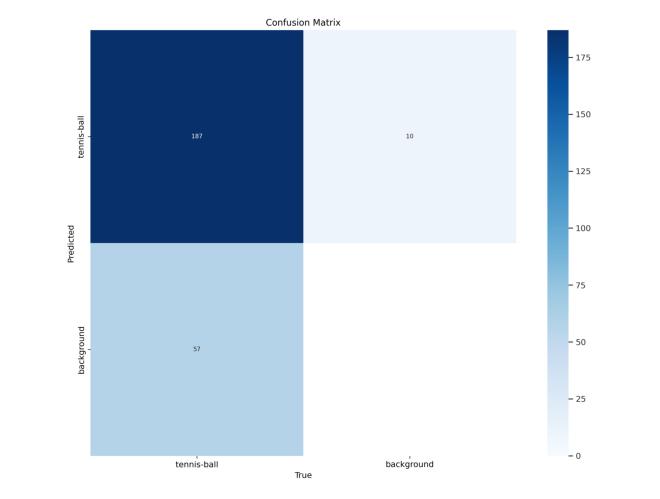

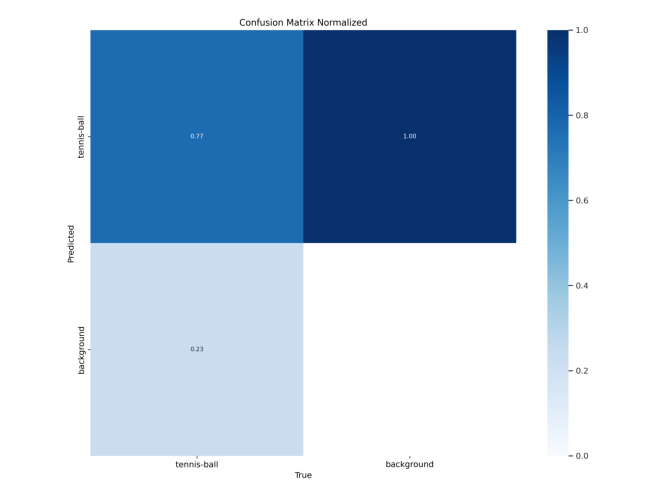

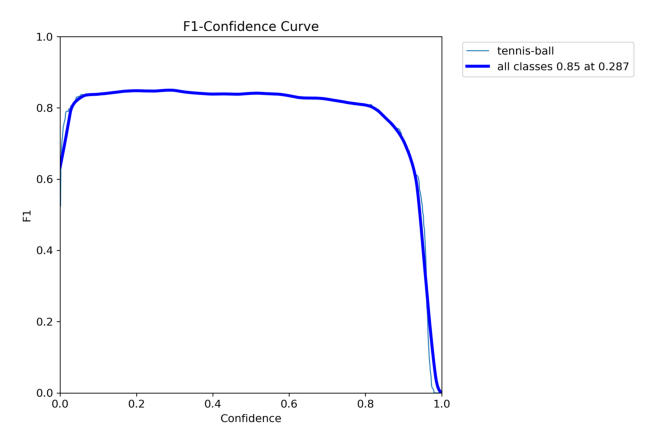

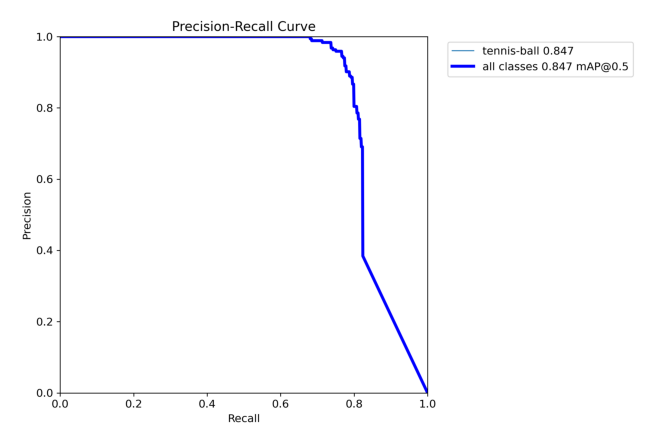

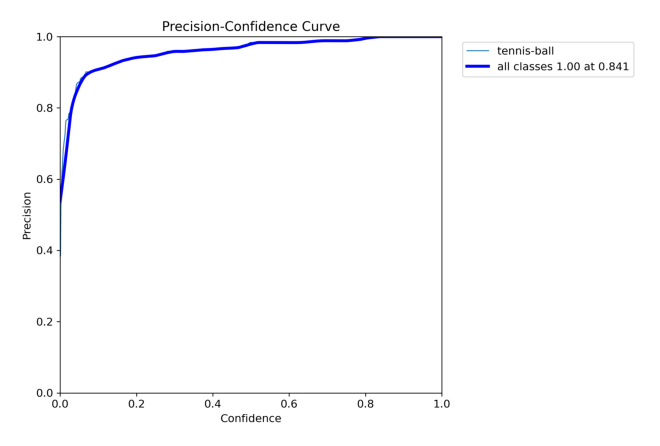

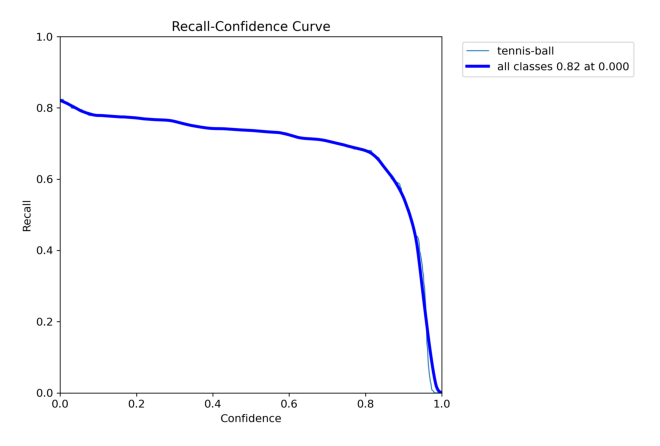

In [ ]:
from clearml import Task
from ultralytics import YOLO

os.chdir(HOME)

project_name = 'Tennis ball detection'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

epochs = 100
variant = 'yolov9s'
optimizer = 'auto'
batch_size = 16

task_name = f'{variant}-{project_name.lower().replace(" ", "-")}-{epochs}-epochs-{optimizer.lower()}-no-stop-resume'
print(f'Task name: {task_name}')

task = Task.init(project_name=project_name, task_name=task_name)

# The model variant
task.set_parameter('model_variant', variant)

model_path = '/content/drive/MyDrive/Data/tennis-best.pt' if exists_model else f'{variant}.pt'
task.set_parameter('model_path', model_path)

# Load model
# model = YOLO(f'{variant}.pt').to(device)
model = YOLO(model_path).to(device)

args = dict(data=f'{dataset.location}/data.yaml',
            epochs=epochs,
            patience=0,
            batch=batch_size,
            optimizer=optimizer,
            device=device,
            resume=exists_model)

task.connect(args)

results = model.train(**args)

#!yolo task=detect mode=train device={device} model=yolov9s.pt data={dataset.location}/data.yaml epochs={epochs} imgsz=640 optimizer={optimizer} batch={batch_size}

task.close()

In [ ]:
path = os.path.join(HOME, 'runs', 'detect', 'train', 'weights')
os.path.exists(path)

True

In [ ]:
import shutil

from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/Data/tennis-best.pt'
shutil.copy('/content/runs/detect/train/weights/best.pt', save_path)

assert os.path.exists(save_path)
print(f'Model copied to: {save_path}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model copied to: /content/drive/MyDrive/Data/tennis-best.pt


In [ ]:
import supervision as sv

img_dir_path = os.path.join(dataset.location, 'test', 'images')
ann_dir_path = os.path.join(dataset.location, 'test', 'labels')
data_yaml_path = os.path.join(dataset.location, 'data.yaml')

supervision_ds = sv.DetectionDataset.from_yolo(
    images_directory_path=img_dir_path,
    annotations_directory_path=ann_dir_path,
    data_yaml_path=data_yaml_path)

Dataset len: 120
Choosen: ['/content/Tennis-6/test/images/178_jpg.rf.a0f43342f3638350ecd13b4b948ae727.jpg', '/content/Tennis-6/test/images/238_jpg.rf.6fbea24f2af251e04bbbc56c78b4e440.jpg', '/content/Tennis-6/test/images/191_jpg.rf.da489a28abe496546c672686b3976278.jpg']
CLASS_NAME_DICT: {0: 'tennis-ball'}

image 1/1 /content/Tennis-6/test/images/178_jpg.rf.a0f43342f3638350ecd13b4b948ae727.jpg: 640x640 1 tennis-ball, 20.3ms
Speed: 1.6ms preprocess, 20.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Model det: Detections(xyxy=array([[     490.44,      394.21,      544.99,      440.51]], dtype=float32), mask=None, confidence=array([     0.8565], dtype=float32), class_id=array([0]), tracker_id=None, data={'class_name': array(['tennis-ball'], dtype='<U11')})

image 1/1 /content/Tennis-6/test/images/238_jpg.rf.6fbea24f2af251e04bbbc56c78b4e440.jpg: 640x640 1 tennis-ball, 20.1ms
Speed: 1.5ms preprocess, 20.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

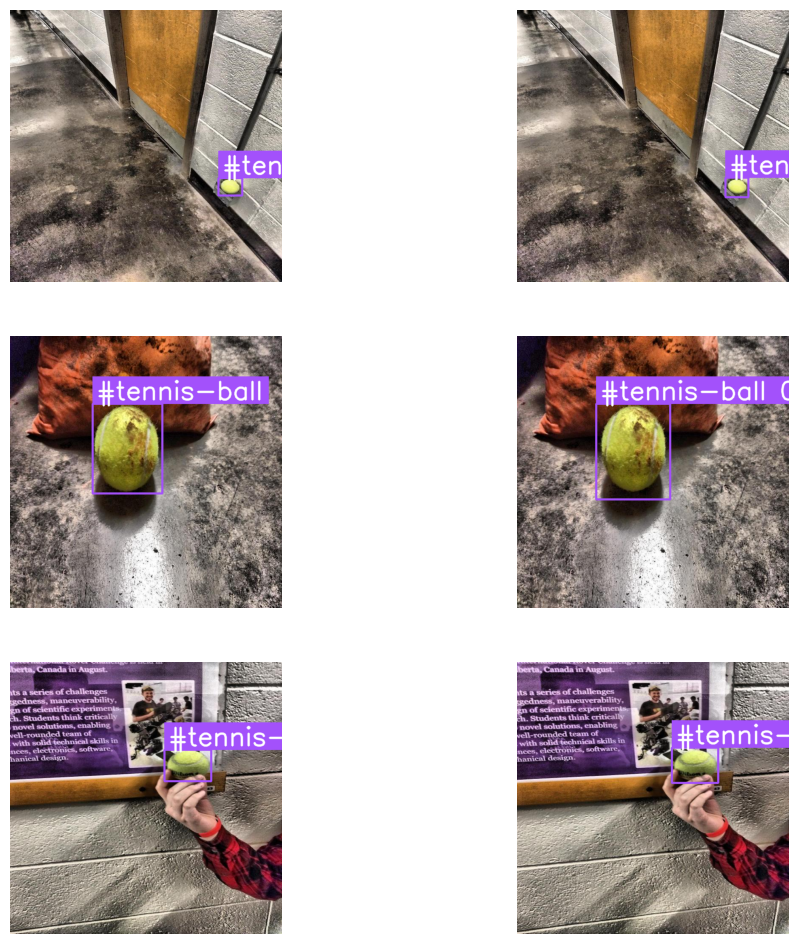

In [ ]:
import random
import cv2

len_ds = len(supervision_ds)
print(f'Dataset len: {len_ds}')

choosen = random.choices(list(supervision_ds.images.keys()), k=3)
print(f'Choosen: {choosen}')

box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

CLASS_NAME_DICT = { idx: label for idx, label in enumerate(supervision_ds.classes) }
print(f'CLASS_NAME_DICT: {CLASS_NAME_DICT}')

frames = []

for img_src in choosen:
  image = cv2.imread(img_src)
  detections = supervision_ds.annotations[img_src]

  labels = [
    f'#{CLASS_NAME_DICT[class_id]}'
    for class_id in detections.class_id
  ]

  frame = box_annotator.annotate(image.copy(), detections)
  frame = label_annotator.annotate(frame, detections, labels=labels)

  frames.append(frame)

  results = model.predict(img_src)
  model_detections = sv.Detections.from_ultralytics(results[0])
  print(f'Model det: {model_detections}')

  labels = [
    f'#{CLASS_NAME_DICT[class_id]} {conf:.2f}'
    for class_id, conf in zip(model_detections.class_id, model_detections.confidence)
  ]

  frame_model = box_annotator.annotate(image.copy(), model_detections)
  frame_model = label_annotator.annotate(frame_model, model_detections, labels=labels)

  frames.append(frame_model)

sv.plot_images_grid(frames, (len(frames) // 2, 2))